# HTT working meeting tutorial: How to train a multi-class neural network

In [1]:
%%bash
# Install the python packages wget via pip locally
pip install --user wget

You are using pip version 9.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Download the training dataset

## Extract variables and event weights from the dataset

Note that the column `training_weight` of the dataset is actually filled with the plotting weights (aka event weights).

In [1]:
import ROOT
import pandas
import numpy as np
np.random.seed(1234)

filename = "training_dataset.root"
# Specify variables which shall be used as input for the neural network
variables = ["pt_1", "pt_2", "m_sv", "mjj"]

def load_tree(filename, treename):
    f = ROOT.TFile(filename)
    t = f.Get(treename)
    data, labels = t.AsMatrix(columns=variables + ["training_weight"], return_labels=True)
    return pandas.DataFrame(data=data, columns=labels)

# Load data from ROOT TTrees to panda dataframes
qqh = load_tree(filename, "qqh")
ztt = load_tree(filename, "ztt")
qcd = load_tree(filename, "ss")

# Show the content of a dataframe
print(qqh)

Welcome to JupyROOT 6.14/04
           pt_1        pt_2        m_sv          mjj  training_weight
0     30.077490   37.230450  133.870728   107.264275         0.006194
1     52.040379   45.533375  112.238113    37.135574         0.005604
2     39.720085   30.551704  105.527939   338.464905         0.005377
3     34.477676   41.167690  111.119858   -11.000000         0.005935
4     52.521873   33.147522  122.413986  1073.543457         0.006253
5     46.549671   32.486320  106.732590    29.103359         0.005773
6     26.148962   37.759727  139.168243    71.211395         0.005496
7     45.587917   46.390606  103.425819  2145.035400         0.005277
8     25.303339   55.061531  110.328293   694.203674         0.005251
9     42.549690   68.646004  132.788849   745.880493         0.005839
10    31.618233   40.076077   93.313187  1611.798584         0.005435
11    62.406921   55.881641  128.867981   434.881775         0.005451
12    31.248795   40.245235  112.653351  1651.349121         0

## Reweight the event weights for training

The event weights need to be reweighted for training so that each process goes in with equal importance.

In [2]:
# Sum of all event weights is needed for reweighting to equal importance
sum_weights = np.sum(qqh["training_weight"]) + np.sum(ztt["training_weight"]) + np.sum(qcd["training_weight"])

# Function to reweight the weights to equal importance
def reweight(df):
    df["training_weight_reweighted"] = df["training_weight"] * sum_weights / np.sum(df["training_weight"])

# Run the reweighting on the pandas dataframe
reweight(qqh)
reweight(ztt)
reweight(qcd)

## Plot variables with reweighted event weights

These are the distributions that the NN sees during training.

In [3]:
import matplotlib.pyplot as plt

# Function to plot a variable
def plot(variable):
    plt.figure()
    range_ = np.percentile(qqh[variable], (5, 95))
    plt.hist(
        [qqh[variable], ztt[variable], qcd[variable]],
        range=range_,
        bins=30,
        weights=[
            qqh["training_weight_reweighted"],
            ztt["training_weight_reweighted"],
            qcd["training_weight_reweighted"]],
        histtype="step",
        lw=2,
        label=("qqh","ztt", "qcd"))
    plt.xlabel(variable)
    plt.legend()

# Loop over variables and plot each one
for var in variables:
    plot(var)

## Prepare data for training

The data needs to be put in a predefined shape so that Keras understands the inputs.

In [4]:
# Function to extract numpy array from pandas dataframe
def load_data(df, index):
    x = df.as_matrix(columns=variables)
    w = df.as_matrix(columns=["training_weight_reweighted"])
    y = np.zeros((x.shape[0], 3))
    y[:, index] = 1
    return x, w, y

# Load data from dataframe to numpy arrays
qqh_x, qqh_w, qqh_y = load_data(qqh, 0)
ztt_x, ztt_w, ztt_y = load_data(ztt, 1)
qcd_x, qcd_w, qcd_y = load_data(qcd, 2)

# Stack numpy arrays of different processes to single array
x = np.vstack([qqh_x, ztt_x, qcd_x])
w = np.vstack([qqh_w, ztt_w, qcd_w]).squeeze()
y = np.vstack([qqh_y, ztt_y, qcd_y])

# Print what we are doing
print("Variables:\n{}\n".format(variables))
print("Inputs:\n{}\n".format(x))
print("Weights:\n{}\n".format(w))
print("Targets:\n{}\n".format(y))

Variables:
['pt_1', 'pt_2', 'm_sv', 'mjj']

Inputs:
[[ 30.07748985  37.23044968 133.87072754 107.2642746 ]
 [ 52.04037857  45.53337479 112.2381134   37.13557434]
 [ 39.72008514  30.55170441 105.52793884 338.46490479]
 ...
 [ 33.68743134  34.11830902 104.98097229 -11.        ]
 [ 29.27093697  30.96722221  95.13156128 -11.        ]
 [ 32.91968155  31.3677063  146.67391968 -11.        ]]

Weights:
[11.27017103 10.1963477   9.78446046 ...  5.2689025   5.2689025
  5.2689025 ]

Targets:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]



/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


## Define neural network architecture

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Stack layers defining neural network architecture
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=len(variables)))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

# Specify loss function and optimizer algorithm
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Print architecture
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset in training and validation part used for the gradient steps and monitoring of the training
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x, y, w, test_size=0.5, random_state=1234)

# Train the neural network
history = model.fit(
                x_train, y_train,
                sample_weight=w_train,
                batch_size=1000,
                epochs=30,
                validation_data=(x_val, y_val, w_val))

## Plot loss convergence

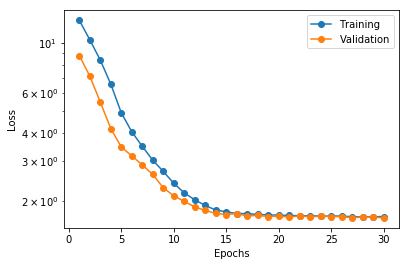

In [9]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend();

## Apply trained model

Note that we apply the model again on the training dataset. In the actual analysis, we would apply the model on the second fold of the full analysis dataset.

In [10]:
# Get neural network prediction for each MC sample
qqh_predictions = model.predict(qqh_x)
ztt_predictions = model.predict(ztt_x)
qcd_predictions = model.predict(qcd_x)

# Print predictions showing probability for each process
print("Predictions of qqh events:\n{}\n".format(
    qqh_predictions))
print("Mean probability per process:\n{}\n".format(
    np.mean(qqh_predictions, axis=0)))

Predictions of qqh events:
[[0.2736749  0.25753364 0.46879146]
 [0.347043   0.3513556  0.3016014 ]
 [0.593255   0.17805952 0.22868548]
 ...
 [0.5602104  0.24110675 0.19868283]
 [0.52661115 0.12178256 0.35160634]
 [0.63795996 0.2009743  0.16106574]]

Mean probability per process:
[0.65141636 0.17605251 0.17253135]



## Fill categories with highest NN score

In [11]:
# These are our processes
processes = ["qqh", "ztt", "qcd"]

# Structure categories
categories = {}
for category in processes: # Make dedicated category for each process
    categories[category] = {}
    for process in processes: # Store NN scores and event weights of each process contributing to this category
        categories[category][process] = {"scores": [], "weights": []}

predictions = {
    "qqh": qqh_predictions,
    "ztt": ztt_predictions,
    "qcd": qcd_predictions
}
weights = {
    "qqh": qqh["training_weight"],
    "ztt": ztt["training_weight"],
    "qcd": qcd["training_weight"]
}

# Loop over processes
for i_process, process in enumerate(processes):
    # Loop over events of this process
    n_events = predictions[process].shape[0]
    for i_event in range(n_events):
        # Find category for this event and retrieve NN score
        p = predictions[process][i_event] # e.g., [0.3, 0.5, 0.2]
        max_index = np.argmax(p)          #             1
        max_score = p[max_index]          #             0.5
        category = processes[max_index]   #             "ztt"
        
        # Store NN score and event weight for this event in respective category
        categories[category][process]["scores"].append(
            max_score
        )
        categories[category][process]["weights"].append(
            weights[process][i_event]
        )

## Plot categories

Note that we use the event weights for plotting, not the reweighted weights used for training.

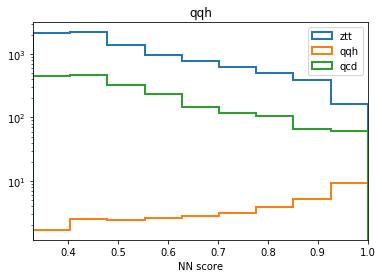

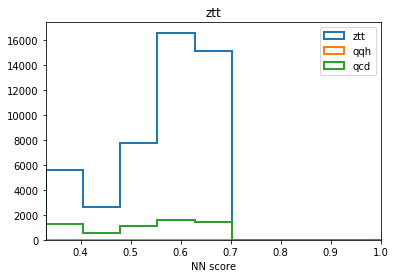

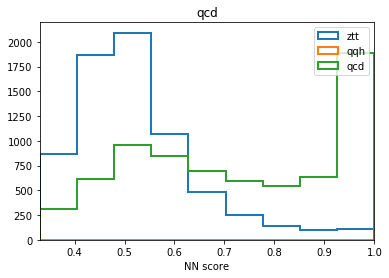

In [12]:
def plot(label, logscale=False):
    category = categories[label]
    plt.figure()
    bins = np.linspace(0.33, 1.0, 10)
    for process in category:
        plt.hist(
            np.array(category[process]["scores"]),
            weights=np.array(category[process]["weights"]),
            bins=bins,
            histtype="step",
            lw=2,
            label=process)
    plt.title(label)
    plt.xlabel("NN score")
    plt.xlim((bins[0], bins[-1]))
    if logscale:
        plt.yscale("log")
    plt.legend()
    
# Plot categories
plot("qqh", logscale=True)
plot("ztt")
plot("qcd")